## Generating Synthetic Dataset
**Authors:**<br>
Lin Lee Cheong <br>
Tesfagabir Meharizghi<br>
Guang Yang<br>

**Date:**<br>
03/31/2021

## Introduction
The purpose of this notebook is to generate synthetic datasets that mimic medical claims datasets while maintaining sufficient ground truth understanding the different model explainability methods, such as attention weights, SHAP and LRP. Each patient is assigned a series of events, with events as proxies of real diagnosis, procedure and medication billing codes. Events fall into four categories: adverse (A), helper (H), unhelper (U) and noise (N). Adverse (A) and helper (H) events represent severe disease diagnoses and lead to higher probabilities of a bad outcome or positive label. Unhelper (U) events symbolize low risk, rewarding procedures that decrease the likelihood of adverse outcome. Noise(N) events represent insignificant, temporary side effects and does not impact the final outcome. Each dataset is categorized in to 7 groups based on the number of non-noise tokens in the sequence. These are:

* `AAH` → 2 adverse and 1 helper tokens
* `AHH` → 1 adverse and 2 helper tokens
* `AH` → 1 adverse and 1 helper tokens
* `AU` → 1 helper and 1 unhelper tokens
* `AUU` → 1 adverse and 2 unhelper tokens
* `HUU` → 1 helper and 2 unhelper tokens
* `UU` → 2 unhelper tokens

There are two types of datasets generated here:

### Event-based Dataset
In this type of dataset, the presence or absence of a set of events or tokens, without regard to the sequence of events, is the primary driver of binary outcome labels. The positive label for each category is driven as follows:
Total number of observations
* `AAH` → 90% of being positive label
* `AHH` → 80% of being positive label
* `AH` → 70% of being positive label
* `AU` → 40% of being positive label
* `AUU` → 30% of being positive label
* `HUU` → 20% of being positive label
* `UU` → 10% of being positive label

### Sequence-based Dataset
These type dataset has a temporal effect where more recent events have a bigger impact on the outcome in the near future.

Positive label is driven by a sequence of tokens
- Positive label probability is driven by the following formula
``` min(1.0, math.exp(-(a * ta)) + math.exp(-(h * th)) - math.exp(-(u * tu))) ```
Where:
- `a` is a constant related to `_A` events. It is the inverse of the contribution of `_A` events for positive label
- `h` is a constant related to `_H` events. It is the inverse of the contribution of `_H` events for positive label
- `u` is a constant related to `_U` events. It is the inverse of the contribution of `_U` events for positive label

- `ta` is the absolute position of the `_A` event in the sequence from the end.
- `th` is the absolute position of the `_H` event in the sequence from the end.
- `tu` is the absolute position of the `_U` event in the sequence from the end.

For more information, refer to this [paper](https://)

## Load Python Packages

In [1]:
%load_ext nb_black

%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import yaml
import string
import os
import numpy as np
import pandas as pd
import math
import random
import json
import seaborn as sns
import matplotlib.pyplot as plt

import utils

<IPython.core.display.Javascript object>

## Define Constants

In [3]:
SEQ_LEN = 30
TOKENS_PATH = "./tokens.yaml"

#Paths for event-based dataset
EVENT_TRAIN_PATH = f"data/event/{SEQ_LEN}/train.csv"
EVENT_VAL_PATH = f"data/event/{SEQ_LEN}/val.csv"
EVENT_TEST_PATH = f"data/event/{SEQ_LEN}/test.csv"

#Paths for sequence-based dataset
SEQUENCE_TRAIN_PATH = f"data/sequence/{SEQ_LEN}/train.csv"
SEQUENCE_VAL_PATH = f"data/sequence/{SEQ_LEN}/val.csv"
SEQUENCE_TEST_PATH = f"data/sequence/{SEQ_LEN}/test.csv"

UID_COLNAME = "patient_id" #Unique ID Column Name
UID_LEN = 10 #Patient ID Length

SEQUENCE_TYPES = ['AAH', 'AHH', 'AH', 'HU', 'AUU', 'HUU', 'UU']
SEQUENCE_BASE_PROBS = [0.9, 0.8, 0.7, 0.4, 0.3, 0.2, 0.1]

# Total patients in the each data split
N_TRAIN = 21000
N_VAL = 7000
N_TEST = 7000

#Total patients for each group/category
N_TRAIN_PER_SEQ_TYPE = N_TRAIN//len(SEQUENCE_TYPES)
N_VAL_PER_SEQ_TYPE = N_VAL//len(SEQUENCE_TYPES)
N_TEST_PER_SEQ_TYPE = N_TEST//len(SEQUENCE_TYPES)

# Mappings of the token groups with the abbreviation
TOKEN_MAPPINGS = {
    "A": "adverse_tokens",
    "H": "adverse_helper_tokens",
    "U": "adverse_unhelper_tokens",
}

<IPython.core.display.Javascript object>

## Generate Dataset

In [4]:
# Load tokens from yaml file path
tokens = utils.load_tokens(TOKENS_PATH)
for key in tokens.keys():
    print(f"{key}: {len(tokens[key])} tokens")

adverse_tokens: 10 tokens
adverse_helper_tokens: 10 tokens
adverse_unhelper_tokens: 10 tokens
noise_tokens: 15 tokens


<IPython.core.display.Javascript object>

In [5]:
#Display all tokens
for key, tok in tokens.items():
    print(key)
    print(f'Total: {len(tok)}')
    print(tok)
    print("-" * 50)

adverse_tokens
Total: 10
['Acute_Myocardial_Infarction_A', 'hypertension_A', 'arrhythmia_A', 'congestive_heart_failure_A', 'heart_valve_failure_A', 'pulmonary_embolism_A', 'ventricular_aneurysm_A', 'ventricular_hypertrophy_A', 'cardiomyopathy_A', 'Chronic_Obstructive_Pulmonary_Disease_A']
--------------------------------------------------
adverse_helper_tokens
Total: 10
['sleep_apnea_H', 'pneumonia_H', 'coronary_artery_disease_H', 'edema_H', 'troponin_H', 'Brain_Natriuretic_Peptide_H', 'alchoholism_H', 'metabolic_disorder_H', 'elevated_creatinine_H', 'electrolyte_imbalance_H']
--------------------------------------------------
adverse_unhelper_tokens
Total: 10
['Percutaneous_Coronary_Intervention_U', 'electrical_cardioversion_U', 'catheter_ablation_U', 'pacemaker_U', 'cardiac_rehab_U', 'sleep_apnea_treatment_U', 'ACE_inhibitors_U', 'ARB_U', 'diuretics_U', 'beta_blockers_U']
--------------------------------------------------
noise_tokens
Total: 15
['eye_exam_N', 'annual_physical_N', 'ha

<IPython.core.display.Javascript object>

### Generate sequence of events for each patient (without target labels)

In [6]:
#Train data
df_train = utils.get_sequences(SEQ_LEN, 
                   tokens=tokens, 
                   token_mappings=TOKEN_MAPPINGS, 
                   seq_types=SEQUENCE_TYPES, 
                   n_seq_per_type=N_TRAIN_PER_SEQ_TYPE, 
                   uid_colname=UID_COLNAME, 
                   uid_len=UID_LEN
                  )

#Validation data
df_val = utils.get_sequences(SEQ_LEN, 
                   tokens=tokens, 
                   token_mappings=TOKEN_MAPPINGS, 
                   seq_types=SEQUENCE_TYPES, 
                   n_seq_per_type=N_VAL_PER_SEQ_TYPE, 
                   uid_colname=UID_COLNAME, 
                   uid_len=UID_LEN
                  )

#Test data
df_test = utils.get_sequences(SEQ_LEN, 
                   tokens=tokens, 
                   token_mappings=TOKEN_MAPPINGS, 
                   seq_types=SEQUENCE_TYPES, 
                   n_seq_per_type=N_TEST_PER_SEQ_TYPE, 
                   uid_colname=UID_COLNAME, 
                   uid_len=UID_LEN
                  )

<IPython.core.display.Javascript object>

In [7]:
print(f'Train: {df_train.shape}, Val: {df_val.shape}, Test: {df_test.shape}')

Train: (21000, 31), Val: (7000, 31), Test: (7000, 31)


<IPython.core.display.Javascript object>

In [8]:
df_train.head()

,29,28,27,26,25,24,23,22,21,20,...,8,7,6,5,4,3,2,1,0,sequence_type
patient_id,,,,,,,,,,,,,,,,,,,,,
42R8IXZIK2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,eye_exam_N,myopia_N,quad_injury_N,pneumonia_H,hay_fever_N,backache_N,Chronic_Obstructive_Pulmonary_Disease_A,hay_fever_N,dental_exam_N,AH
YU03GXIPV2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ACL_tear_N,annual_physical_N,troponin_H,congestive_heart_failure_A,myopia_N,peanut_allergy_N,backache_N,hay_fever_N,myopia_N,AH
Q1915GS5V5,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,cut_finger_N,...,ingrown_nail_N,cold_sore_N,cold_sore_N,ingrown_nail_N,pneumonia_H,myopia_N,dental_exam_N,dental_exam_N,hay_fever_N,AHH
4S1YJIM5NK,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,alchoholism_H,eye_exam_N,ACL_tear_N,ACL_tear_N,ankle_sprain_N,ventricular_aneurysm_A,dental_exam_N,peanut_allergy_N,annual_physical_N,AH
6W22CK0326,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,foot_pain_N,backache_N,catheter_ablation_U,hay_fever_N,headache_N,pacemaker_U,myopia_N,annual_physical_N,foot_pain_N,HUU


<IPython.core.display.Javascript object>

### Generate event-based dataset with target labels

In [9]:
#Train Data (event-based)
df_train_event = utils.generate_dataset(df_train,
                           SEQ_LEN, 
                           seq_types=SEQUENCE_TYPES, 
                           seq_base_probs=SEQUENCE_BASE_PROBS,
                           data_type='event'
                           )

#Val Data (event-based)
df_val_event = utils.generate_dataset(df_val,
                           SEQ_LEN, 
                           seq_types=SEQUENCE_TYPES, 
                           seq_base_probs=SEQUENCE_BASE_PROBS,
                           data_type='event'
                           )

#Test Data (event-based)
df_test_event = utils.generate_dataset(df_test,
                           SEQ_LEN, 
                           seq_types=SEQUENCE_TYPES, 
                           seq_base_probs=SEQUENCE_BASE_PROBS,
                           data_type='event'
                           )

<IPython.core.display.Javascript object>

In [10]:
print(df_train_event.shape)
df_train_event.head()

(21000, 33)


,29,28,27,26,25,24,23,22,21,20,...,6,5,4,3,2,1,0,sequence_type,proba,label
patient_id,,,,,,,,,,,,,,,,,,,,,
42R8IXZIK2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,quad_injury_N,pneumonia_H,hay_fever_N,backache_N,Chronic_Obstructive_Pulmonary_Disease_A,hay_fever_N,dental_exam_N,AH,0.7,1
YU03GXIPV2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,troponin_H,congestive_heart_failure_A,myopia_N,peanut_allergy_N,backache_N,hay_fever_N,myopia_N,AH,0.7,1
Q1915GS5V5,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,cut_finger_N,...,cold_sore_N,ingrown_nail_N,pneumonia_H,myopia_N,dental_exam_N,dental_exam_N,hay_fever_N,AHH,0.8,1
4S1YJIM5NK,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ACL_tear_N,ACL_tear_N,ankle_sprain_N,ventricular_aneurysm_A,dental_exam_N,peanut_allergy_N,annual_physical_N,AH,0.7,1
6W22CK0326,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,catheter_ablation_U,hay_fever_N,headache_N,pacemaker_U,myopia_N,annual_physical_N,foot_pain_N,HUU,0.2,0


<IPython.core.display.Javascript object>

### Generate sequence-based dataset with target labels

In [11]:
#Train Data(sequence-based)
df_train_seq = utils.generate_dataset(df_train,
                           SEQ_LEN, 
                           seq_types=SEQUENCE_TYPES, 
                           seq_base_probs=SEQUENCE_BASE_PROBS,
                           data_type='sequence'
                           )

#Validation Data(sequence-based)
df_val_seq = utils.generate_dataset(df_val,
                           SEQ_LEN, 
                           seq_types=SEQUENCE_TYPES, 
                           seq_base_probs=SEQUENCE_BASE_PROBS,
                           data_type='sequence'
                           )

#Test Data(sequence-based)
df_test_seq = utils.generate_dataset(df_test,
                           SEQ_LEN, 
                           seq_types=SEQUENCE_TYPES, 
                           seq_base_probs=SEQUENCE_BASE_PROBS,
                           data_type='sequence'
                           )

<IPython.core.display.Javascript object>

In [12]:
print(df_train_seq.shape)
df_train_seq.head()

(21000, 33)


,29,28,27,26,25,24,23,22,21,20,...,6,5,4,3,2,1,0,sequence_type,proba,label
patient_id,,,,,,,,,,,,,,,,,,,,,
42R8IXZIK2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,quad_injury_N,pneumonia_H,hay_fever_N,backache_N,Chronic_Obstructive_Pulmonary_Disease_A,hay_fever_N,dental_exam_N,AH,1.0000,1
YU03GXIPV2,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,troponin_H,congestive_heart_failure_A,myopia_N,peanut_allergy_N,backache_N,hay_fever_N,myopia_N,AH,0.9077,1
Q1915GS5V5,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,cut_finger_N,...,cold_sore_N,ingrown_nail_N,pneumonia_H,myopia_N,dental_exam_N,dental_exam_N,hay_fever_N,AHH,0.6597,0
4S1YJIM5NK,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ACL_tear_N,ACL_tear_N,ankle_sprain_N,ventricular_aneurysm_A,dental_exam_N,peanut_allergy_N,annual_physical_N,AH,0.9427,1
6W22CK0326,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,catheter_ablation_U,hay_fever_N,headache_N,pacemaker_U,myopia_N,annual_physical_N,foot_pain_N,HUU,0.1000,0


<IPython.core.display.Javascript object>

## Data Visualization

### Distribution of Tokens

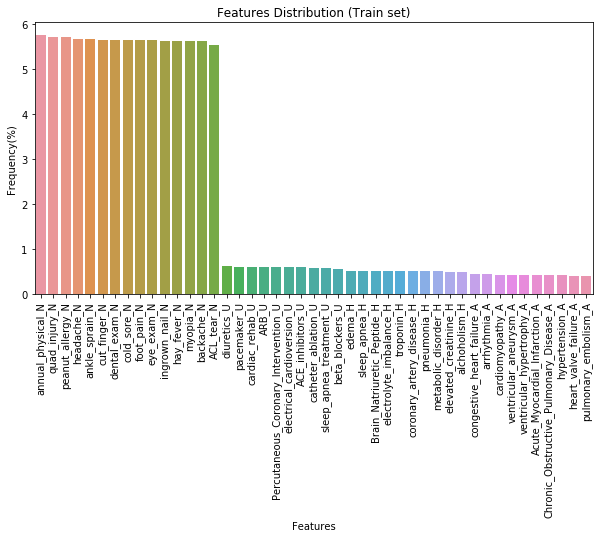

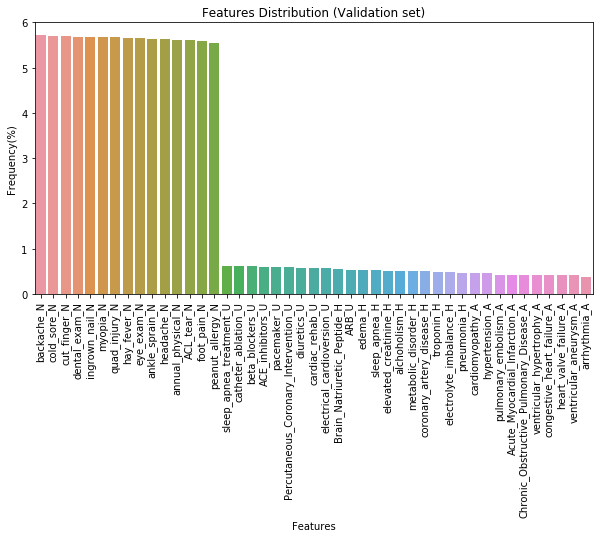

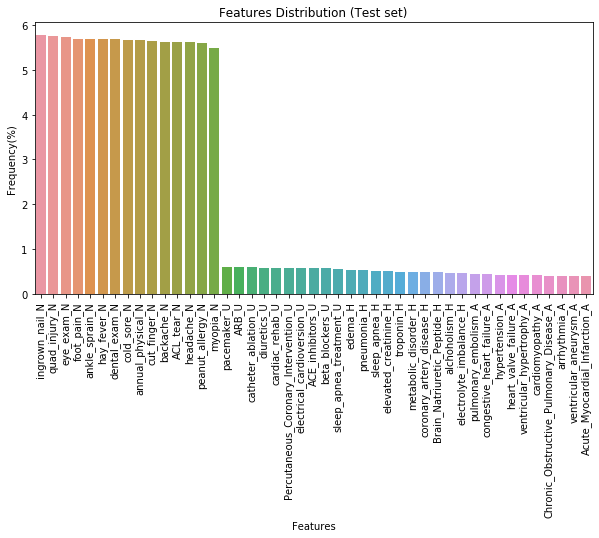

<IPython.core.display.Javascript object>

In [13]:
#Train Data
utils.plot_features_distribution(df_train, seq_len=SEQ_LEN, split="Train", normalize=True)

#Val Data
utils.plot_features_distribution(df_val, seq_len=SEQ_LEN, split="Validation", normalize=True)

#Test Data
utils.plot_features_distribution(df_test, seq_len=SEQ_LEN, split="Test", normalize=True)

### Class Imbalance

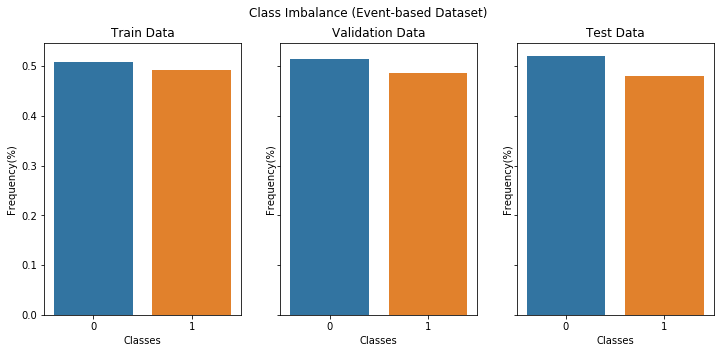

<IPython.core.display.Javascript object>

In [14]:
#Event-based Dataset
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
fig.suptitle('Class Imbalance (Event-based Dataset)')
values = df_train_event.label.value_counts(normalize=True)
sns.barplot(ax=axes[0], x=values.index, y=values.values)
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Frequency(%)')
axes[0].set_title('Train Data')

values = df_val_event.label.value_counts(normalize=True)
sns.barplot(ax=axes[1], x=values.index, y=values.values)
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Frequency(%)')
axes[1].set_title('Validation Data')

values = df_test_event.label.value_counts(normalize=True)
sns.barplot(ax=axes[2], x=values.index, y=values.values)
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Frequency(%)')
axes[2].set_title('Test Data')

plt.show()

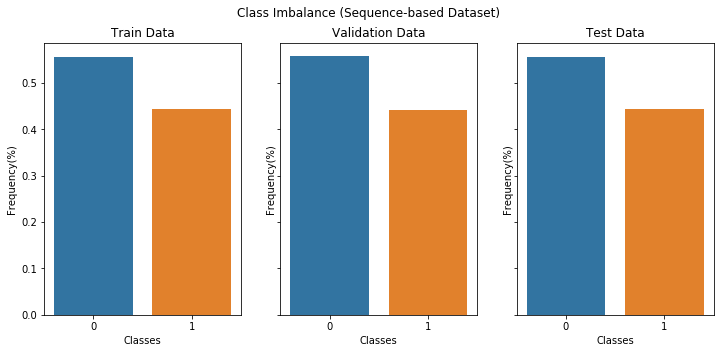

<IPython.core.display.Javascript object>

In [15]:
#Sequence-based Dataset
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
fig.suptitle('Class Imbalance (Sequence-based Dataset)')
values = df_train_seq.label.value_counts(normalize=True)
sns.barplot(ax=axes[0], x=values.index, y=values.values)
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Frequency(%)')
axes[0].set_title('Train Data')

values = df_val_seq.label.value_counts(normalize=True)
sns.barplot(ax=axes[1], x=values.index, y=values.values)
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Frequency(%)')
axes[1].set_title('Validation Data')

values = df_test_seq.label.value_counts(normalize=True)
sns.barplot(ax=axes[2], x=values.index, y=values.values)
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Frequency(%)')
axes[2].set_title('Test Data')

plt.show()

### Distribution of probabilities for each sequence types

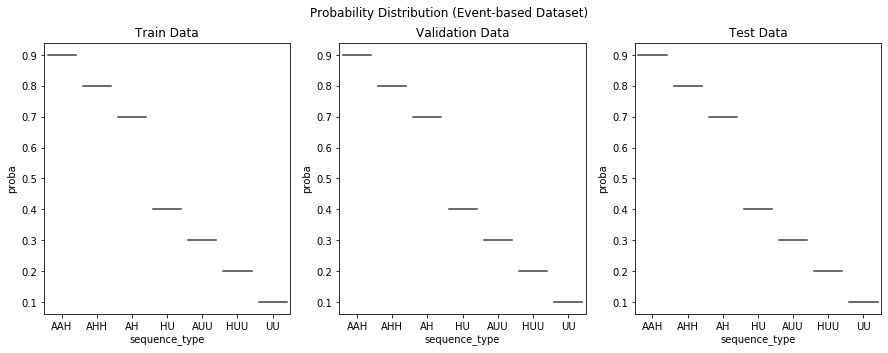

<IPython.core.display.Javascript object>

In [16]:
#Event-based dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Probability Distribution (Event-based Dataset)')
sns.violinplot(ax=axes[0], x="sequence_type", y="proba", data=df_train_event, order=SEQUENCE_TYPES)
axes[0].set_title('Train Data')

sns.violinplot(ax=axes[1], x="sequence_type", y="proba", data=df_val_event, order=SEQUENCE_TYPES)
axes[1].set_title('Validation Data')

sns.violinplot(ax=axes[2], x="sequence_type", y="proba", data=df_test_event, order=SEQUENCE_TYPES)
axes[2].set_title('Test Data')
#sns.despine()
plt.show()

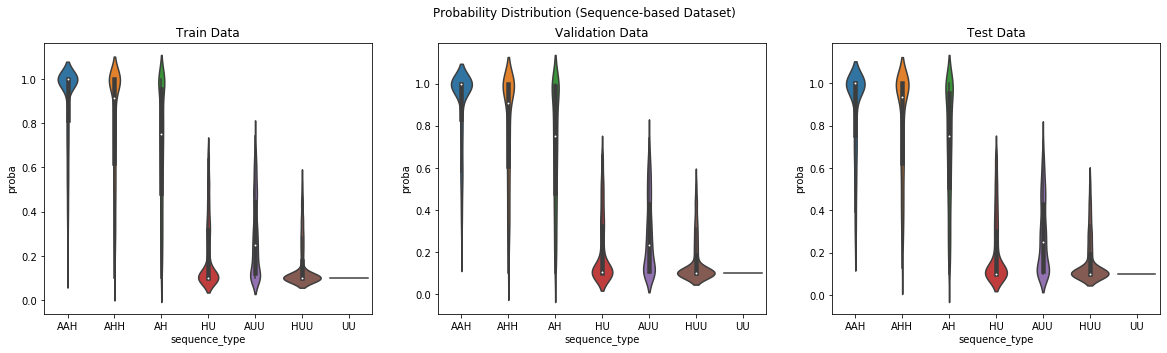

<IPython.core.display.Javascript object>

In [17]:
#Sequence-based dataset
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Probability Distribution (Sequence-based Dataset)')
sns.violinplot(ax=axes[0], x="sequence_type", y="proba", data=df_train_seq, order=SEQUENCE_TYPES)
axes[0].set_title('Train Data')

sns.violinplot(ax=axes[1], x="sequence_type", y="proba", data=df_val_seq, order=SEQUENCE_TYPES)
axes[1].set_title('Validation Data')

sns.violinplot(ax=axes[2], x="sequence_type", y="proba", data=df_test_seq, order=SEQUENCE_TYPES)
axes[2].set_title('Test Data')
#sns.despine()
plt.show()

## Save Data

In [18]:
#Event-based
output_dir = os.path.dirname(EVENT_TRAIN_PATH)
os.makedirs(output_dir, exist_ok=True)

df_train_event.to_csv(EVENT_TRAIN_PATH)
df_val_event.to_csv(EVENT_VAL_PATH)
df_test_event.to_csv(EVENT_TEST_PATH)
print('Successfully Saved!')

Successfully Saved!


<IPython.core.display.Javascript object>

In [19]:
#Sequence-based
output_dir = os.path.dirname(SEQUENCE_TRAIN_PATH)
os.makedirs(output_dir, exist_ok=True)

df_train_seq.to_csv(SEQUENCE_TRAIN_PATH)
df_val_seq.to_csv(SEQUENCE_VAL_PATH)
df_test_seq.to_csv(SEQUENCE_TEST_PATH)
print('Successfully Saved!')

Successfully Saved!


<IPython.core.display.Javascript object>